# Goal

The goal of this analysis is to retrieve all similar pairs of car loans to determine if these similar loans received the same interest raste

In [1]:
import pandas as pd
df = pd.read_csv('cleaned.csv')

C:\Users\sweet\AppData\Local\Temp\ipykernel_27736\871723915.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned.csv')


In [2]:
df.head()

,assetNumber,originalLoanAmount,originalLoanTerm,Scheduled Payment Amount,interestRate,reportingPeriodEndingDate,originalFirstPaymentDate,underwritingIndicator,gracePeriodNumber,subvented,...,nextReportingPeriodPaymentAmountDue,currentDelinquencyStatus,reportingPeriodBeginningDate,originatorName,originationDate,loanMaturityDate,vehicleManufacturerName,vehicleModelName,reportingPeriodBeginningLoanBalanceAmount,obligorGeographicLocation
0,537581964,40873.54,72,601.109763,0.0190,2/28/2022,5/1/2021,0.0,0,1,...,1202.22,1.0,2/1/2022,TMCC,05/2021,04/2027,LEXUS,LX IS 300,36573.22,CA
1,362660414,34991.78,72,561.918571,0.0490,2/28/2022,3/1/2021,0.0,0,1,...,864.96,1.0,2/1/2022,TMCC,03/2021,02/2027,TOYOTA,SIENNA,29932.87,CT
2,234565769,25777.35,72,379.096519,0.0190,2/28/2022,8/1/2020,0.0,0,1;2,...,758.18,1.0,2/1/2022,TMCC,08/2020,07/2026,TOYOTA,CAMRY,19605.36,CA
3,224112672,21659.20,72,380.708480,0.0809,2/28/2022,8/1/2020,0.0,0,2,...,761.40,1.0,2/1/2022,TMCC,08/2020,07/2026,TOYOTA,CAMRY,17164.56,CA
4,530166042,36085.40,72,666.693978,0.0990,2/28/2022,5/1/2021,0.0,0,2,...,666.69,0.0,2/1/2022,TMCC,05/2021,05/2027,TOYOTA,VENZA,33178.82,CA


In [3]:
df.shape[0]

5402476

In [4]:
df.originatorName.unique()

array(['TMCC', 'Fifth Third Bank National Association',
       'BMW Bank of North America', 'Exeter Finance',
       'WORLD OMNI FINANCIAL CORP', 'Ally Bank', 'Ford Credit', 'NMAC',
       'USAAFSB', 'VW Credit', 'AHFC', 'MBFS USA LLC', 'SC',
       'Carvana, LLC', 'Mechanics Bank'], dtype=object)

In [5]:
import itertools

Criteria:  
Same Model Year  
Same Model  
Same Loan Term  
Same Origination Month  
Vehicle Value: +- 10% of value A  
Credit Score: +- 7 points of value A  
PTI: +- 10% of value A  
Loan Amount: +- 5%   

In [33]:
# Retrieves combinations
def getCombos(dat, vehicle_years, vehicle_models, loan_terms, orig_dates):
    
    output = []
    
    num_rows = dat[(dat['vehicleModelYear'].isin(vehicle_years)) & (dat['vehicleModelName'].isin(vehicle_models)) & 
                      (dat['originalLoanTerm'].isin(loan_terms)) & (dat['originationDate'].isin(orig_dates))].shape[0]
    
    # For every combination of year, model, term, and origination date
    for v_year, v_model, l_term, orig_date in itertools.product(vehicle_years, vehicle_models, loan_terms, orig_dates):
        # filter dataset to these years
        result = dat[(dat['vehicleModelYear']==v_year) & (dat['vehicleModelName']==v_model) & 
                      (dat['originalLoanTerm']==l_term) & (dat['originationDate']==orig_date)]
        # If there is at least 1 combination,
        if result.shape[0] < 2:
            continue
        # For every combination of rows in resulting set
        for combo in itertools.combinations(result.values, 2):
            # determine if within 7 obligorCreditScore points
            if not abs(combo[0][13] - combo[1][13]) < 8:
                continue
            # determine if within 5% of originalLoanAmount
            if not abs(combo[0][1] - combo[1][1]) < (0.05 * combo[0][1]):
                continue
            # determine if within 10% of paymentToIncomePercentage
            if not abs(combo[0][17] - combo[1][17]) < (0.1 * combo[0][17]):
                continue
            # determine if within 10% of vehicleValueAmount
            if not abs(combo[0][12] - combo[1][12]) < (0.1 * combo[0][12]):
                continue
            # Append combination to list, using itertools.chain to flatten combo to single element
            output.append(list(itertools.chain(*combo)))
    # generate column names for resulting dataframe
    A_names = [col + ' A' for col in list(df.columns)]
    B_names = [col + ' B' for col in list(df.columns)]
    # convert list to dataframe
    output = pd.DataFrame(output, columns=A_names+B_names)
    # record rows of source dataset for context
    output['total_rows'] = num_rows
    # record absolute difference in interest rate
    output['interest_diff'] = abs(output['interestRate A'] - output['interestRate B'])
    return output

I will be starting with Volkswagen Credit, a captive originator. Due to the size of the data and the vastness of the combinations needed to assess, I will be filtering this data down using analysis done in tableau.

In [34]:
vw = df[df['originatorName'] == 'VW Credit']

Using the quantity of loans distributed across vehicle years, I chose to only concentrate on years 2017 and higher.

In [35]:
import itertools, numpy as np
vehicle_years = [2017, 2018, 2019, 2020, 2021]
vehicle_years

[2017, 2018, 2019, 2020, 2021]

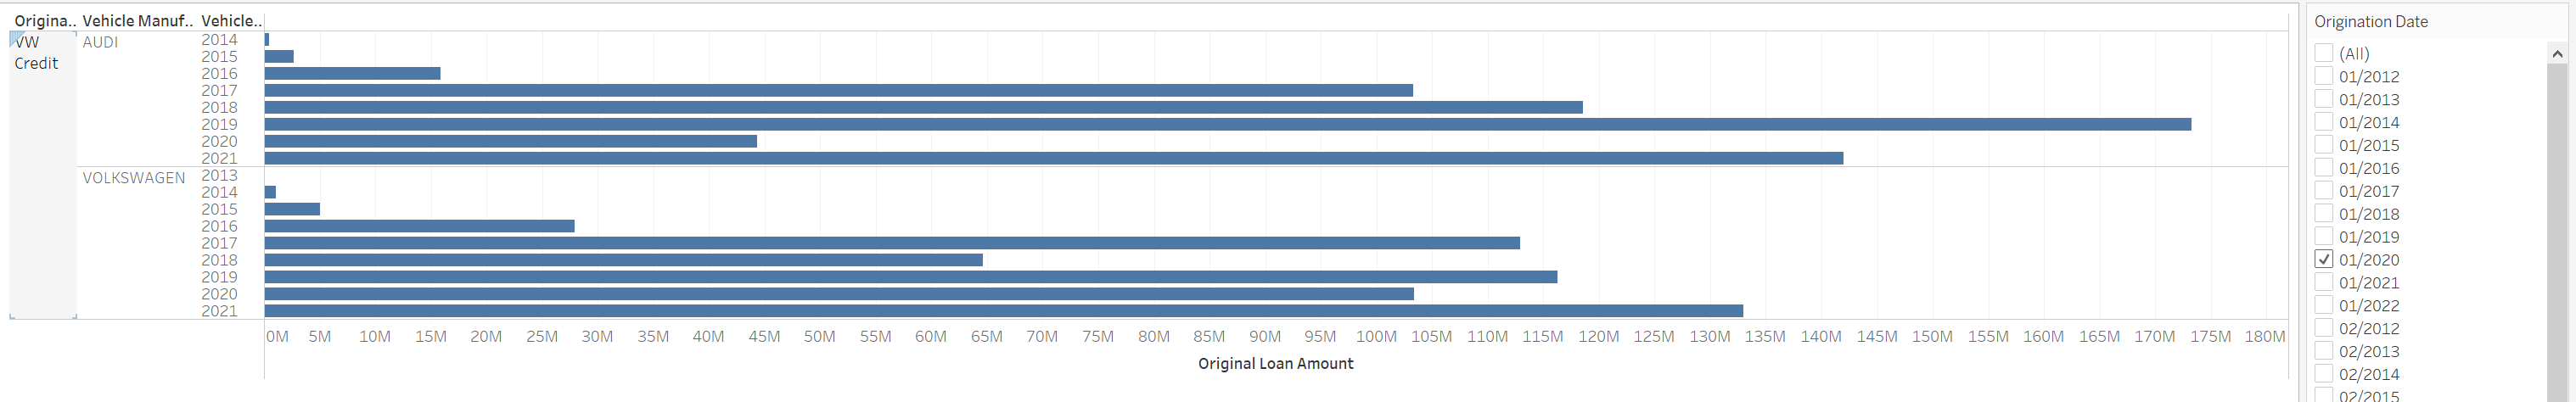

Likewise, I chose only the models that sold more than $10M in loans

In [36]:
vehicle_models = ['A3', 'A4', 'A5', 'A6', 'E-TRON', 'Q3', 'Q5', 'Q7', 'Q8', 'S5', 'ATLAS', 'BEETLE', 'GLI', 'GOLF',
                  'GTI', 'JETTA', 'PASSAT', 'TIGUAN']
vehicle_models

['A3',
 'A4',
 'A5',
 'A6',
 'E-TRON',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'S5',
 'ATLAS',
 'BEETLE',
 'GLI',
 'GOLF',
 'GTI',
 'JETTA',
 'PASSAT',
 'TIGUAN']

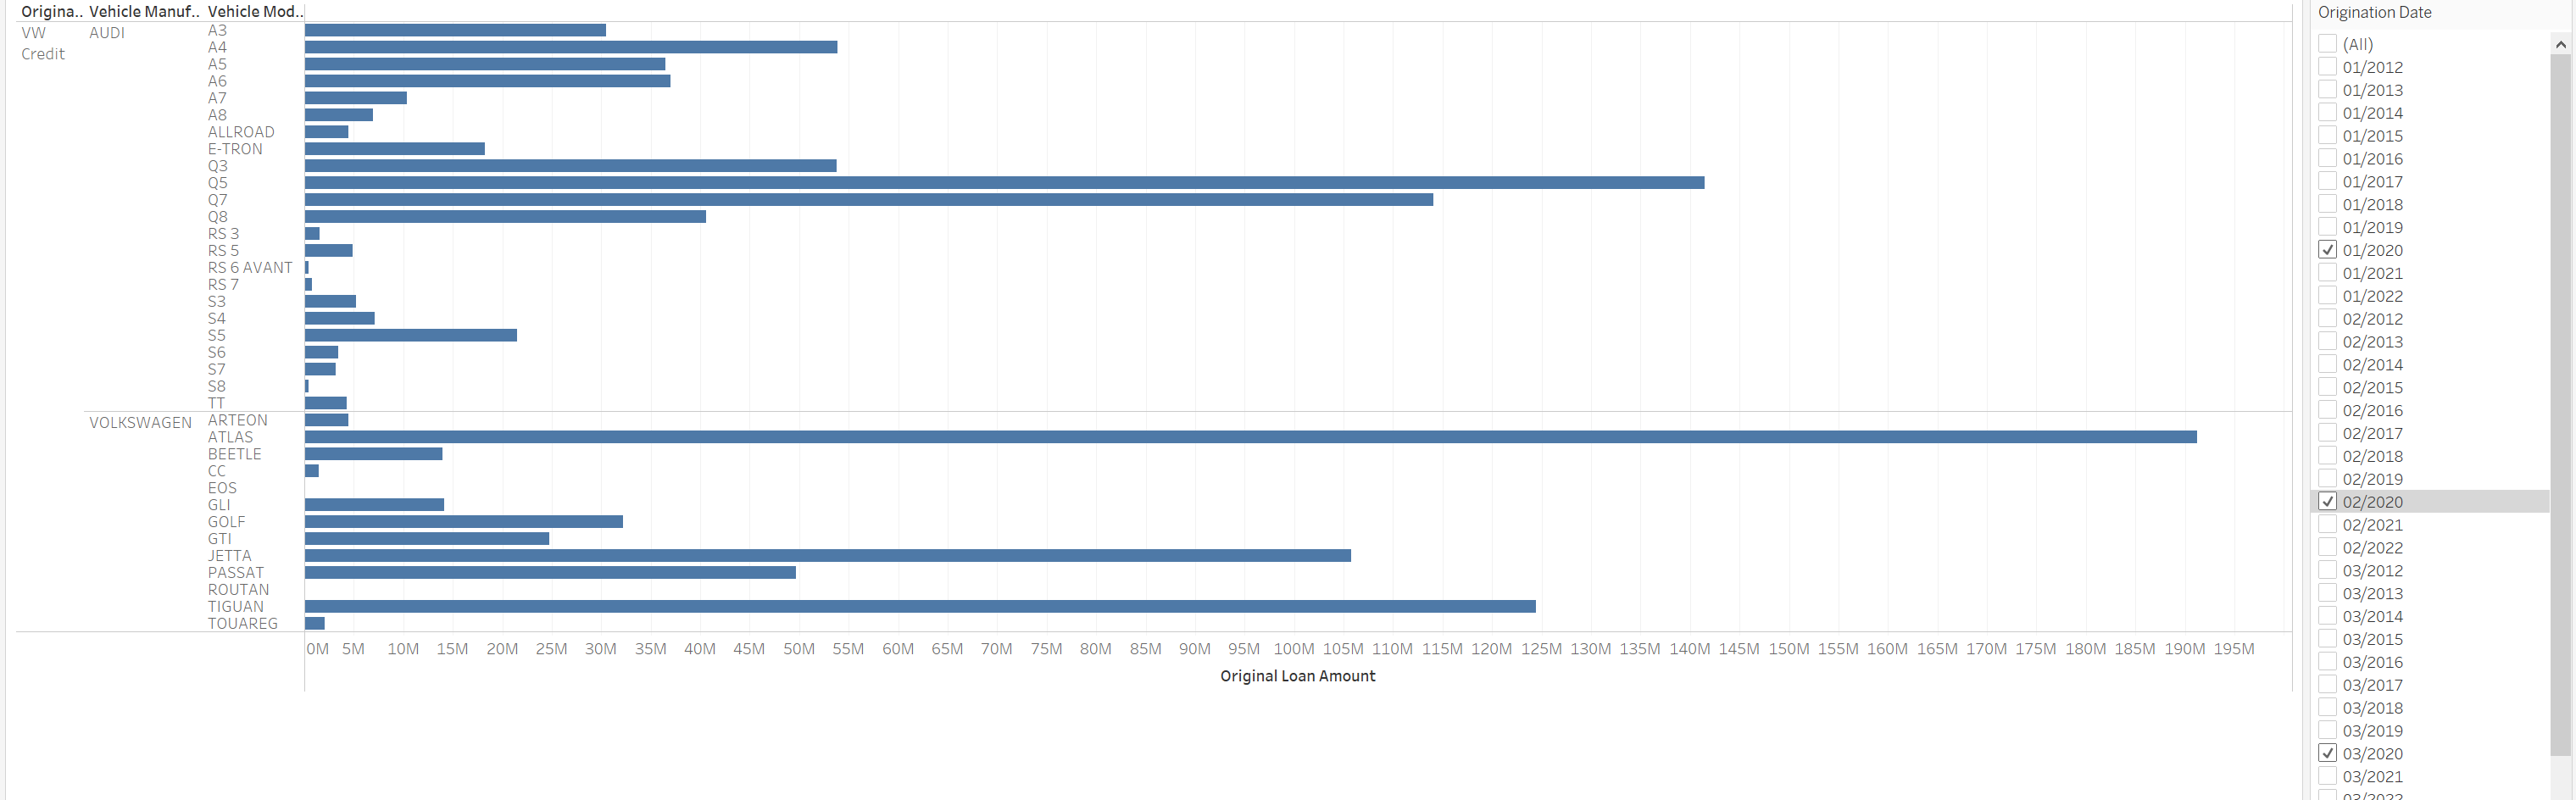

In [37]:
loan_terms = [24, 36, 48, 60, 66, 72]
loan_terms

[24, 36, 48, 60, 66, 72]

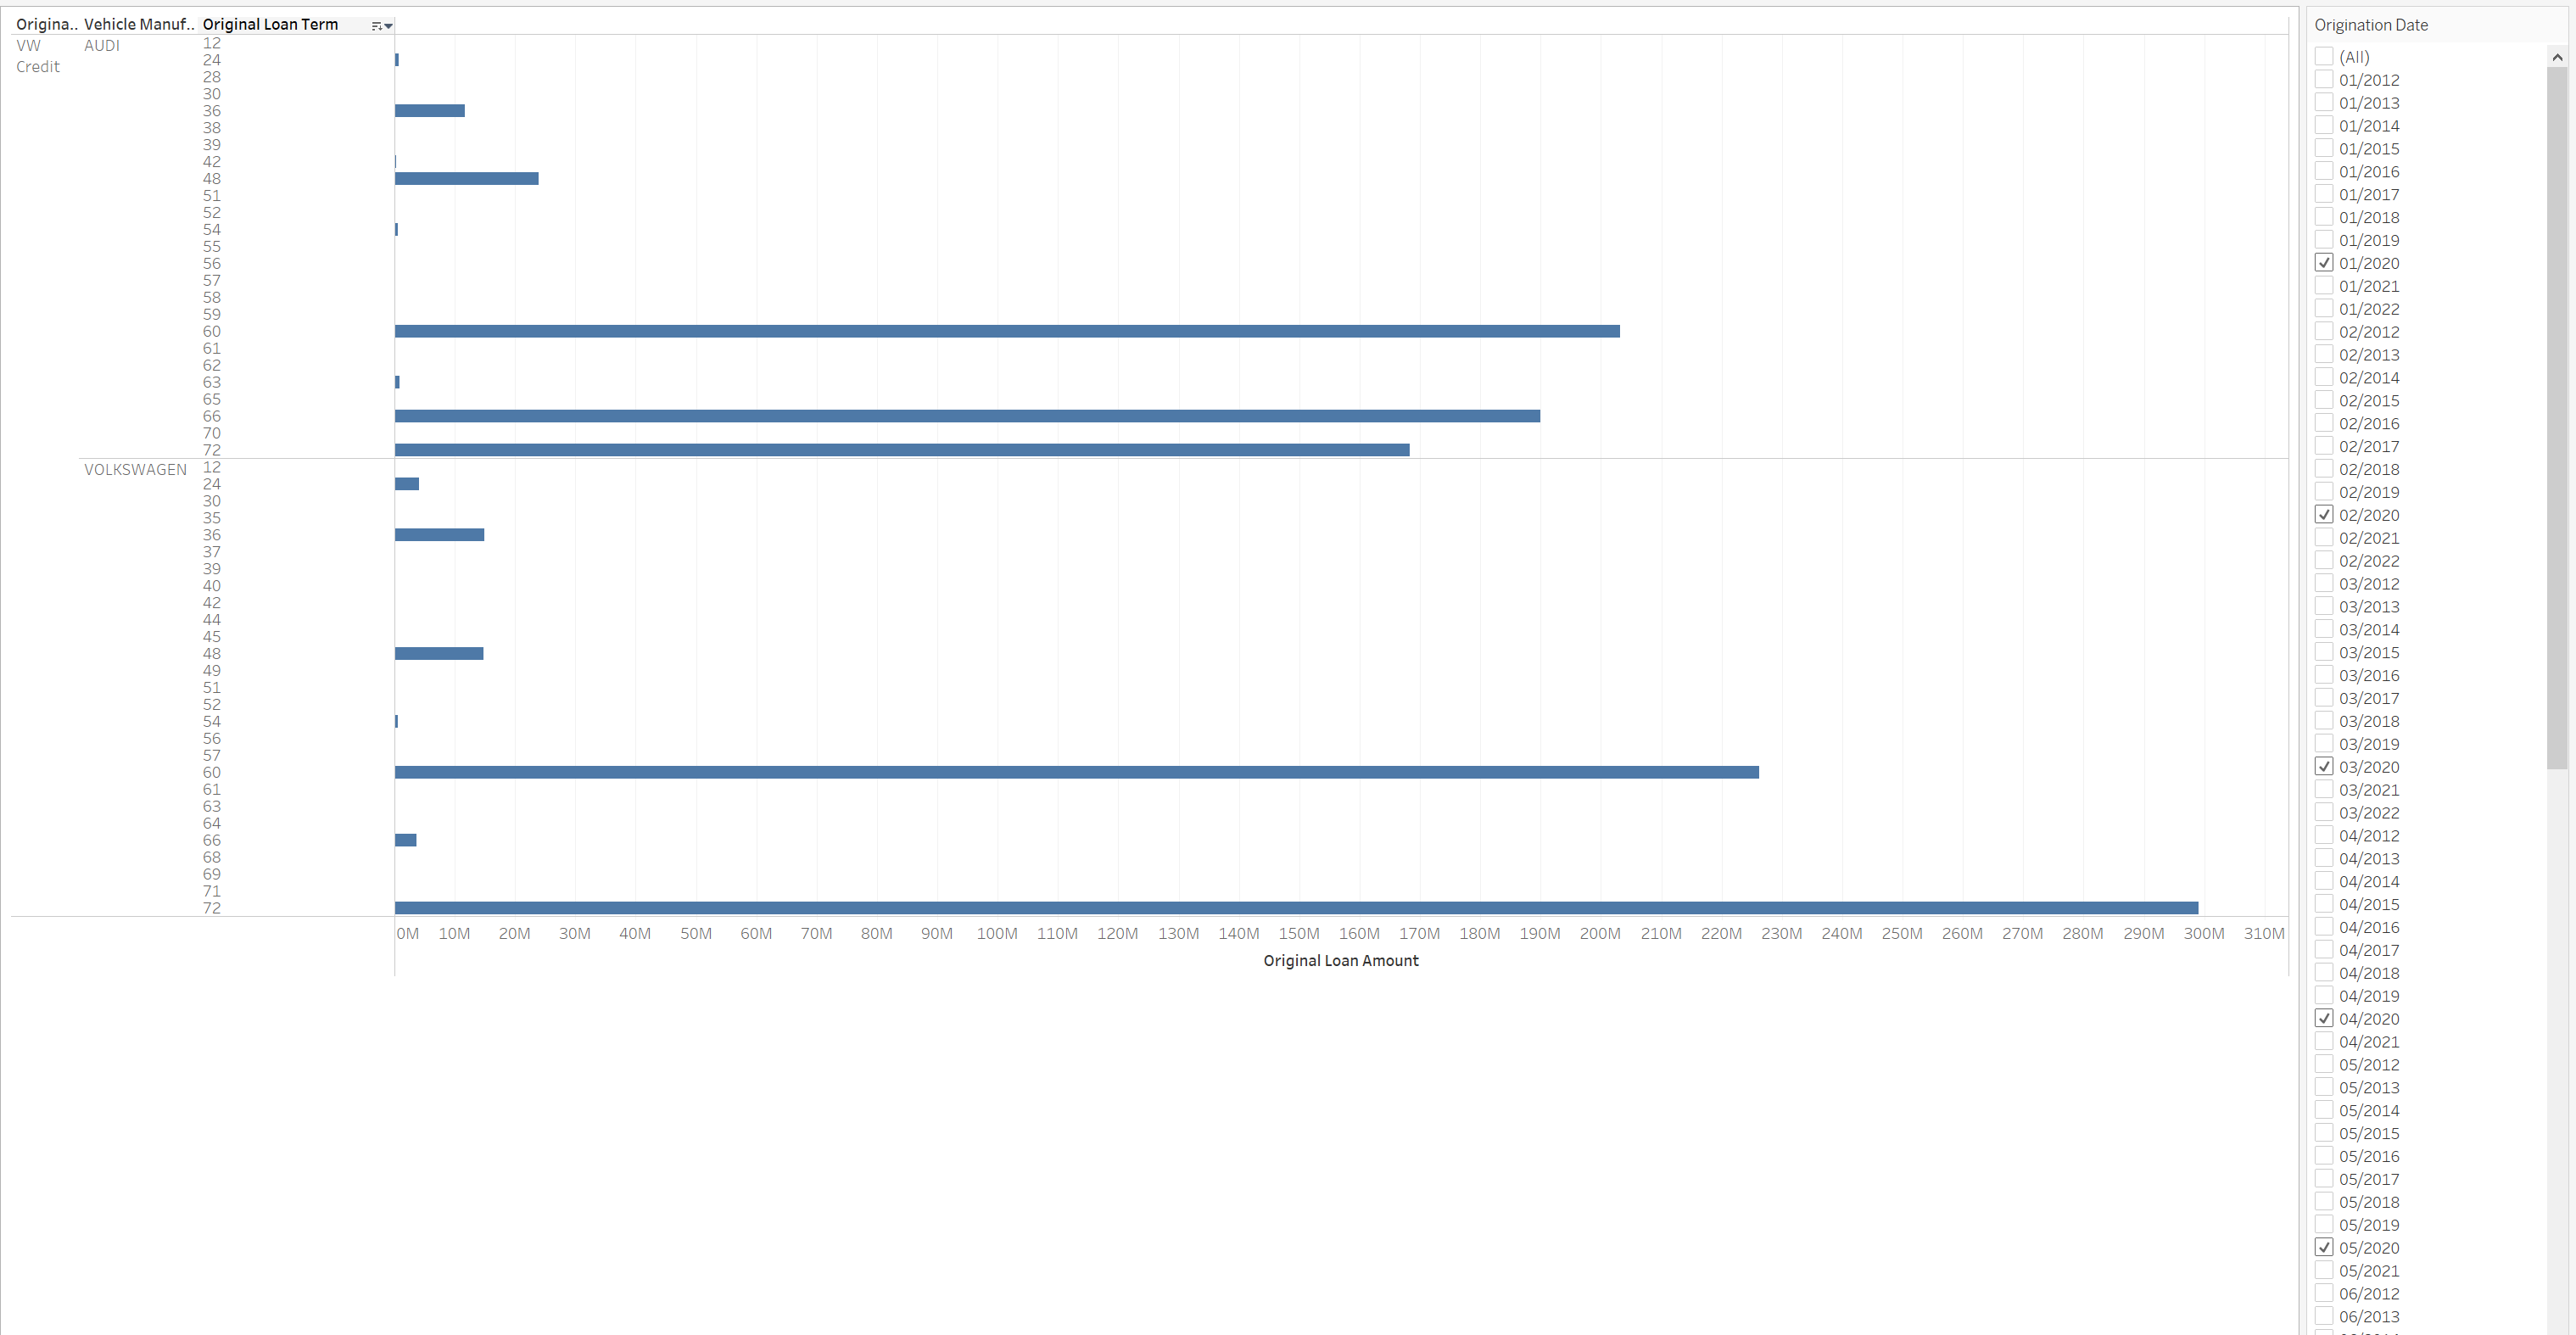

Likewise, I only focused on the latest full year data was available for all originators

In [38]:
orig_dates = ['01/2020', '02/2020', '03/2020', '04/2020', '05/2020', '06/2020', '07/2020', '08/2020',
              '09/2020', '10/2020', '11/2020', '12/2020']
orig_dates

['01/2020',
 '02/2020',
 '03/2020',
 '04/2020',
 '05/2020',
 '06/2020',
 '07/2020',
 '08/2020',
 '09/2020',
 '10/2020',
 '11/2020',
 '12/2020']

In [39]:
vw_combos = getCombos(vw, vehicle_years, vehicle_models, loan_terms, orig_dates)
vw_combos

,assetNumber A,originalLoanAmount A,originalLoanTerm A,Scheduled Payment Amount A,interestRate A,reportingPeriodEndingDate A,originalFirstPaymentDate A,underwritingIndicator A,gracePeriodNumber A,subvented A,...,reportingPeriodBeginningDate B,originatorName B,originationDate B,loanMaturityDate B,vehicleManufacturerName B,vehicleModelName B,reportingPeriodBeginningLoanBalanceAmount B,obligorGeographicLocation B,total_rows,interest_diff
0,246424390,17534.99,60,315.002894,0.0299,3/31/2022,3/1/2020,0.0,2,1,...,3/1/2022,VW Credit,01/2020,01/2025,AUDI,A3,10504.52,FL,35905,0.0100
1,256344894,22264.19,60,408.623829,0.0386,3/31/2022,12/1/2020,0.0,2,0,...,3/1/2022,VW Credit,10/2020,10/2025,AUDI,A3,16321.98,CA,35905,0.0000
2,247253164,21299.47,66,359.957788,0.0399,3/31/2022,3/1/2020,0.0,1,1,...,3/1/2022,VW Credit,02/2020,09/2025,AUDI,A3,0.00,CT,35905,0.0100
3,250963934,23789.25,66,380.826672,0.0199,3/31/2022,7/1/2020,1.0,1,1,...,3/1/2022,VW Credit,06/2020,01/2026,AUDI,A3,17474.68,WA,35905,0.0000
4,246589136,20102.13,60,361.119632,0.0299,3/31/2022,3/1/2020,1.0,2,1,...,3/1/2022,VW Credit,01/2020,01/2025,AUDI,A4,11787.54,WI,35905,0.0100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,258250496,24359.28,72,358.241567,0.0190,3/31/2022,1/1/2021,0.0,1,1,...,3/1/2022,VW Credit,12/2020,01/2027,VOLKSWAGEN,TIGUAN,21452.68,NC,35905,0.0000
625,258197056,41531.00,72,610.778748,0.0190,3/31/2022,1/1/2021,0.0,1,1,...,3/1/2022,VW Credit,12/2020,12/2026,VOLKSWAGEN,TIGUAN,35196.93,IL,35905,0.0000
626,258386910,26871.53,72,395.188159,0.0190,3/31/2022,1/1/2021,1.0,1,1,...,3/1/2022,VW Credit,12/2020,01/2027,VOLKSWAGEN,TIGUAN,23149.45,TX,35905,0.0178
627,258279056,30834.19,72,477.923852,0.0368,3/31/2022,1/1/2021,1.0,1,0,...,3/1/2022,VW Credit,12/2020,12/2026,VOLKSWAGEN,TIGUAN,24202.31,AZ,35905,0.0000


In [40]:
max(vw_combos['interest_diff'])

0.06760000000000001

In [41]:
np.mean(vw_combos['interest_diff'])

0.0076775834658187585

In [42]:
vw_combos.to_csv('vw.csv')

In [43]:
omni_toy = df[(df['originatorName'] == 'WORLD OMNI FINANCIAL CORP') & (df['vehicleManufacturerName'] == 'TOYOTA')]

In [44]:
vehicle_years = [2019, 2020, 2021]

In [45]:
vehicle_models = ['4RUNNER', 'AVALON', 'C-HR', 'CAMRY', 'CAMRY HYBR', 'COROLLA', 'COROLLA HA', 'COROLLA HY', 'HIGHLANDER'
                  'PRIUS', 'RAV4', 'RAV4 HYBRI', 'TACOMA SR', 'TACOMA SR5', 'TACOMA TRD', 'TUNDRA 4X2', 'TUNDRA 4X4']

In [46]:
loan_terms = [49, 50, 61, 62, 63, 73, 74, 75, 76, 77, 78, 79, 80]

In [47]:
omni_combos = getCombos(omni_toy, vehicle_years, vehicle_models, loan_terms, orig_dates)
omni_combos

,assetNumber A,originalLoanAmount A,originalLoanTerm A,Scheduled Payment Amount A,interestRate A,reportingPeriodEndingDate A,originalFirstPaymentDate A,underwritingIndicator A,gracePeriodNumber A,subvented A,...,reportingPeriodBeginningDate B,originatorName B,originationDate B,loanMaturityDate B,vehicleManufacturerName B,vehicleModelName B,reportingPeriodBeginningLoanBalanceAmount B,obligorGeographicLocation B,total_rows,interest_diff
0,998989999995755802,27955.60,73,443.636403,0.0490,2/28/2022,2/1/2020,1.0,1,1,...,2/1/2022,WORLD OMNI FINANCIAL CORP,01/2020,04/2026,TOYOTA,C-HR,22550.81,FL,116597,0.0200
1,998989999995753646,29161.95,76,547.957188,0.1189,2/28/2022,2/1/2020,1.0,1,0,...,2/1/2022,WORLD OMNI FINANCIAL CORP,01/2020,04/2026,TOYOTA,C-HR,0.00,FL,116597,0.0125
2,998989999995576622,24829.46,76,416.151190,0.0789,2/28/2022,1/1/2021,1.0,1,0,...,2/1/2022,WORLD OMNI FINANCIAL CORP,12/2020,03/2027,TOYOTA,CAMRY,21750.18,FL,116597,0.0025
3,998989999995676174,24362.03,77,487.189890,0.1445,2/28/2022,8/1/2020,1.0,2,0,...,2/1/2022,WORLD OMNI FINANCIAL CORP,06/2020,10/2026,TOYOTA,CAMRY,20593.16,SC,116597,0.0025
4,998989999995685738,18176.89,73,353.930833,0.1220,2/28/2022,7/1/2020,1.0,1,0,...,2/1/2022,WORLD OMNI FINANCIAL CORP,06/2020,06/2026,TOYOTA,COROLLA,0.00,FL,116597,0.0150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12811,998989999995583762,48294.27,76,765.154118,0.0599,2/28/2022,1/1/2021,1.0,1,0,...,2/1/2022,WORLD OMNI FINANCIAL CORP,12/2020,03/2027,TOYOTA,TUNDRA 4X4,38888.20,SC,116597,0.0095
12812,998989999995581466,53860.04,76,880.418658,0.0704,2/28/2022,1/1/2021,1.0,1,0,...,2/1/2022,WORLD OMNI FINANCIAL CORP,12/2020,03/2027,TOYOTA,TUNDRA 4X4,44049.58,FL,116597,0.0070
12813,998989999995606660,42859.31,77,665.700334,0.0569,2/28/2022,12/1/2020,1.0,2,0,...,2/1/2022,WORLD OMNI FINANCIAL CORP,10/2020,02/2027,TOYOTA,TUNDRA 4X4,36463.14,SC,116597,0.0100
12814,998989999995575835,55554.57,78,861.621863,0.0599,2/28/2022,3/1/2021,1.0,3,0,...,2/1/2022,WORLD OMNI FINANCIAL CORP,12/2020,05/2027,TOYOTA,TUNDRA 4X4,49428.60,WA,116597,0.0265


In [48]:
max(omni_combos['interest_diff'])

0.12300000000000001

In [49]:
np.mean(omni_combos['interest_diff'])

0.014430058520599252

In [51]:
omni_combos.to_csv('omni.csv')

In [ ]:
# For Every Originator,
    # Record initial number of rows (shape[0]) to determine what proportion of total loans experience this
    # https://docs.python.org/3/library/itertools.html#itertools.product
    
    # For Every(Vehicle Year/Vehicle Model/Term/OrigDate) 
        # Filter Dataset by Every Vehicle Year, Model, Term, Origination Date

        # If length of result.shape[0] < 2, continue. 

        # if thresholds are met for vehicle value, credit score, pti, and loan amount using combination iterator
        #      Calculate difference in Auto A vs Auto B interest rate
        #      Append to dataframe with matches
        # https://docs.python.org/3/library/itertools.html#itertools.combinations
        
    # Insert initial number of rows as a constant column in matches dataframe    
    # sort dataframe by descending difference in rates
    # save matches dataframe for that originator to csv
    # wipe matches